In [137]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                            AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [138]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

# Model

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable

class SpectrumIndexPlotter:
    def __init__(self):
        """初始化绘图类"""
        self.model_data = None
        
    def calculate_axis_range(self, data_values, model_values=None, padding=0.1):
        """
        计算坐标轴范围，考虑数据点和模型网格
        
        参数:
        data_values: array-like, 数据点的值
        model_values: array-like, 模型网格的值（可选）
        padding: float, 范围扩展比例（默认0.1，即10%）
        
        返回:
        (min_val, max_val): tuple, 计算得到的范围
        """
        all_values = []
        
        if data_values is not None:
            all_values.extend(data_values)
        
        if model_values is not None:
            all_values.extend(model_values)
        
        if not all_values:
            return None
        
        min_val = min(all_values)
        max_val = max(all_values)
        
        range_size = max_val - min_val
        
        min_val = min_val - range_size * padding
        max_val = max_val + range_size * padding
        
        return (min_val, max_val)

    def plot_single_panel(self, ax, model_data, x_index, y_index, x_range, y_range, ages,
                         data_df, data_name, color_data, color_label, color_range,
                         annotate=True, show_errorbar=False,
                         hist_width="12%", cbar_width="4%",
                         hist_pad=0.02, cbar_pad=0.02):
        """
        绘制单个panel
        
        参数:
        ax: matplotlib axes对象
        model_data: DataFrame, 模型网格数据
        x_index, y_index: str, 指数名称
        x_range, y_range: tuple, 坐标范围
        ages: list, 年龄列表
        data_df: DataFrame, 观测数据
        data_name: dict, 数据列名映射
        color_data: array, 颜色数据
        color_label: str, 颜色标签
        color_range: tuple, 颜色范围
        annotate: bool, 是否添加标注
        show_errorbar: bool, 是否显示误差棒
        hist_width: str, 直方图宽度比例
        cbar_width: str, colorbar宽度比例
        hist_pad: float, 直方图间距
        cbar_pad: float, colorbar间距
        """
        # 处理Fe指数
        if x_index == 'Fe':
            model_data['Fe'] = (model_data['Fe5270'] + model_data['Fe5335']) / 2
        if y_index == 'Fe':
            model_data['Fe'] = (model_data['Fe5270'] + model_data['Fe5335']) / 2
        
        # 筛选特定年龄的数据
        age_data = model_data[model_data['Age'] == ages[0]].copy()
        
        # 获取独特的ZoH和AoFe值
        zoh_unique = sorted(age_data['ZoH'].unique())
        aofe_unique = sorted(age_data['AoFe'].unique())
        
        # 绘制ZoH网格线
        for zoh in zoh_unique:
            zoh_data = age_data[age_data['ZoH'] == zoh]
            ax.plot(zoh_data[x_index], zoh_data[y_index], '-', 
                   color='tab:blue', alpha=0.5, linewidth=1)
        
        # 绘制AoFe网格线
        for aofe in aofe_unique:
            aofe_data = age_data[age_data['AoFe'] == aofe]
            ax.plot(aofe_data[x_index], aofe_data[y_index], '--', 
                   color='tab:red', alpha=0.5, linewidth=1)
        
        # 添加网格点和标注
        if annotate:
            for zoh in zoh_unique:
                for aofe in aofe_unique:
                    point_data = age_data[(age_data['ZoH'] == zoh) & (age_data['AoFe'] == aofe)]
                    x_val = point_data[x_index].values[0]
                    y_val = point_data[y_index].values[0]
                    
                    ax.scatter(x_val, y_val, color='black', s=20)
                    label = f'[Z/H]={zoh:.2f}\n[α/Fe]={aofe:.1f}'
                    ax.annotate(label, (x_val, y_val), 
                              xytext=(5, 5), textcoords='offset points',
                              fontsize=6, alpha=0.7,
                              bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        # 绘制数据点和误差棒
        if show_errorbar:
            x_err_col = data_name['x'] + '_err'
            y_err_col = data_name['y'] + '_err'
            if x_err_col in data_df.columns and y_err_col in data_df.columns:
                ax.errorbar(data_df[data_name['x']], data_df[data_name['y']],
                          xerr=data_df[x_err_col],
                          yerr=data_df[y_err_col],
                          fmt='none', ecolor='gray',
                          alpha=0.3, capsize=2)
        
        # 创建colorbar和直方图的位置
        divider = make_axes_locatable(ax)
        hist_ax = divider.append_axes("right", size=hist_width, pad=hist_pad)
        cax = divider.append_axes("right", size=cbar_width, pad=cbar_pad)
        
        # 绘制散点图
        scatter = ax.scatter(data_df[data_name['x']], data_df[data_name['y']], 
                           c=color_data,
                           vmin=color_range[0] if color_range else None,
                           vmax=color_range[1] if color_range else None,
                           cmap='inferno', 
                           s=30, alpha=0.7)
        
        # 计算直方图数据
        hist_range = color_range if color_range else (np.min(color_data), np.max(color_data))
        counts, bin_edges = np.histogram(color_data, bins=20, range=hist_range)
        
        # 创建外轮廓线条的数据点
        outline = []
        # 起始点（左下角）
        outline.append((0, bin_edges[0]))
        
        # 上边轮廓线
        for i in range(len(counts)):
            outline.append((counts[i], bin_edges[i]))    # 左上角
            outline.append((counts[i], bin_edges[i+1]))  # 右上角
            
        # 回到起点（右下角和左下角）
        outline.append((0, bin_edges[-1]))
        outline.append((0, bin_edges[0]))
        
        outline = np.array(outline)
        
        # 绘制直方图外轮廓
        hist_ax.plot(outline[:,0], outline[:,1], 'k-', linewidth=1.0)
        
        # 设置直方图的样式
        hist_ax.set_ylim(hist_range)
        max_count = counts.max()
        hist_ax.set_xlim(max_count * 1.1, 0)  # 反转x轴，使直方图朝左
        
        # 设置直方图刻度
        hist_ax.set_xlabel('Count', fontsize=8)
        hist_ax.tick_params(axis='both', which='both', labelsize=8)
        hist_ax.yaxis.set_visible(False)  # 隐藏y轴刻度
        
        # 添加colorbar
        cbar = plt.colorbar(scatter, cax=cax)
        if color_label:
            cbar.set_label(color_label, fontsize=10)
        cbar.ax.tick_params(labelsize=8)
        cbar.ax.tick_params(which='both', direction='in', length=4, width=0.8)
        cbar.locator = plt.MaxNLocator(5)
        cbar.update_ticks()
        
        # 创建图例
        legend_elements = [
            Line2D([0], [0], color='tab:blue', linestyle='-', label='constant [Z/H]'),
            Line2D([0], [0], color='tab:red', linestyle='--', label='constant [α/Fe]')
        ]
        ax.legend(handles=legend_elements, loc='upper left', fontsize=8)
        
        # 设置坐标轴样式
        ax.set_xlabel(x_index, fontsize=12)
        ax.set_ylabel(y_index, fontsize=12)
        ax.set_title(f'Age = {ages[0]} Gyr', fontsize=14)
        
        # 设置坐标轴范围
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        
        # 设置刻度样式
        ax.tick_params(axis='both', which='both', labelsize='x-small', 
                      right=True, top=True, direction='in')
        
        # 设置主次刻度
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        
        # 添加网格
        ax.grid(True, which='major', linestyle='-', alpha=0.2)
        ax.grid(True, which='minor', linestyle=':', alpha=0.1)
        
        # 调整边框样式
        for spine in ax.spines.values():
            spine.set_linewidth(1)

    def plot_index_grid(self, data_file, x_index, y_index, x_range=None, y_range=None, 
                       ages=None, data_df=None, data_name=None, color_params=None,
                       annotate=True, show_errorbar=False, layout=None,
                       # 控制参数
                       base_size=7,          # 基础图形大小
                       height_scale=1.2,     # 高度缩放比例
                       width_ratios=1.4,     # 宽度比例（考虑右侧直方图和colorbar）
                       wspace=0.8,           # 子图之间的水平间距
                       hspace=0.3,           # 子图之间的垂直间距
                       dpi=300,              # 图形DPI
                       hist_width="12%",     # 直方图宽度比例
                       cbar_width="4%",      # colorbar宽度比例
                       hist_pad=0.02,        # 直方图间距
                       cbar_pad=0.02,        # colorbar间距
                       fig_scale=1.5         # 画布整体缩放比例
                       ):
        """
        绘制光谱指数网格图
        
        参数:
        data_file: str, 模型网格数据文件路径
        x_index, y_index: str, 指数名称
        x_range, y_range: tuple or None, 坐标范围
        ages: list, 年龄列表
        data_df: DataFrame, 观测数据
        data_name: dict, 数据列名映射
        color_params: list of dict, 颜色参数列表
        annotate: bool, 是否添加标注
        show_errorbar: bool, 是否显示误差棒
        layout: tuple, 可选, 指定子图布局 (rows, cols)
        base_size: float, 基础图形大小
        height_scale: float, 高度缩放比例
        width_ratios: float, 宽度比例
        wspace: float, 子图之间的水平间距
        hspace: float, 子图之间的垂直间距
        dpi: int, 图形DPI
        hist_width: str, 直方图宽度比例
        cbar_width: str, colorbar宽度比例
        hist_pad: float, 直方图间距
        cbar_pad: float, colorbar间距
        fig_scale: float, 画布整体缩放比例
        """
        # 读取模型网格数据
        self.model_data = pd.read_csv(data_file)
        
        # 如果未指定年龄，使用默认值
        if ages is None:
            ages = [self.model_data['Age'].iloc[0]]
        
        # 自动计算坐标轴范围
        if x_range is None:
            x_model_values = self.model_data[x_index].values
            x_data_values = data_df[data_name['x']].values if data_df is not None else None
            x_range = self.calculate_axis_range(x_data_values, x_model_values)
        
        if y_range is None:
            y_model_values = self.model_data[y_index].values
            y_data_values = data_df[data_name['y']].values if data_df is not None else None
            y_range = self.calculate_axis_range(y_data_values, y_model_values)
        
        # 计算panel布局
        n_colors = len(color_params)
        if layout is None:
            n_rows = (n_colors + 1) // 2
            n_cols = min(2, n_colors)
        else:
            n_rows, n_cols = layout
            if n_rows * n_cols < n_colors:
                raise ValueError(f"Layout {layout} cannot accommodate {n_colors} plots")
        
        # 计算数据范围比例
        x_data_range = x_range[1] - x_range[0]
        y_data_range = y_range[1] - y_range[0]
        data_aspect_ratio = y_data_range / x_data_range
        
        # 计算基础单位大小，考虑数据范围比例
        fig_width = base_size * n_cols * width_ratios * fig_scale
        fig_height = base_size * n_rows * data_aspect_ratio * height_scale * fig_scale
        
        fig, axes = plt.subplots(n_rows, n_cols, 
                                figsize=(fig_width, fig_height),
                                dpi=dpi, facecolor='white')
        
        # 确保axes是二维数组
        if n_rows == 1 and n_cols == 1:
            axes = np.array([[axes]])
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # 绘制每个panel
        for idx, color_param in enumerate(color_params):
            if layout is None:
                row = idx // 2
                col = idx % 2
            else:
                row = idx // n_cols
                col = idx % n_cols
            
            ax = axes[row, col]
            
            self.plot_single_panel(ax, self.model_data, x_index, y_index, 
                                 x_range, y_range, ages,
                                 data_df, data_name, 
                                 data_df[color_param['column']],
                                 color_param['label'],
                                 color_param['range'],
                                 annotate,
                                 show_errorbar,
                                 hist_width=hist_width,
                                 cbar_width=cbar_width,
                                 hist_pad=hist_pad,
                                 cbar_pad=cbar_pad)
        
        # 移除多余的subplot
        if n_colors < n_rows * n_cols:
            for idx in range(n_colors, n_rows * n_cols):
                if layout is None:
                    row = idx // 2
                    col = idx % 2
                else:
                    row = idx // n_cols
                    col = idx % n_cols
                fig.delaxes(axes[row, col])
        
        # 调整子图间距
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        
        return fig

In [140]:
Fit_name = 'Fit_DS_28[25Mar05][VCC1588][AgeZ]'
galaxy_name = 'VCC_1588'
Galaxy_VNB = pd.read_csv('./../FitData/'+Fit_name+'/'+galaxy_name+'_VNB_SFR.csv')

In [141]:
Galaxy_VNB[:1]

,Unnamed: 0,H_beta_EL_value,H_beta_EL_ANR,O_3_5007_EL_value,O_3_5007_EL_ANR,Component_Sol,H_beta_SI,Mg_b_SI,Fe_5015_SI,Age,MOH,R,SNR,Signal,Noise,K_index
0,0,53.792228,41.434208,13.397847,7.68856,"[array([-247.57982875, 20. ]), array(...",3.155343,1.589557,3.46626,2.234762,-0.570609,0.004989,31.834672,0.999196,0.031387,[ 696 697 698 699 700 701 702 703 704 ...


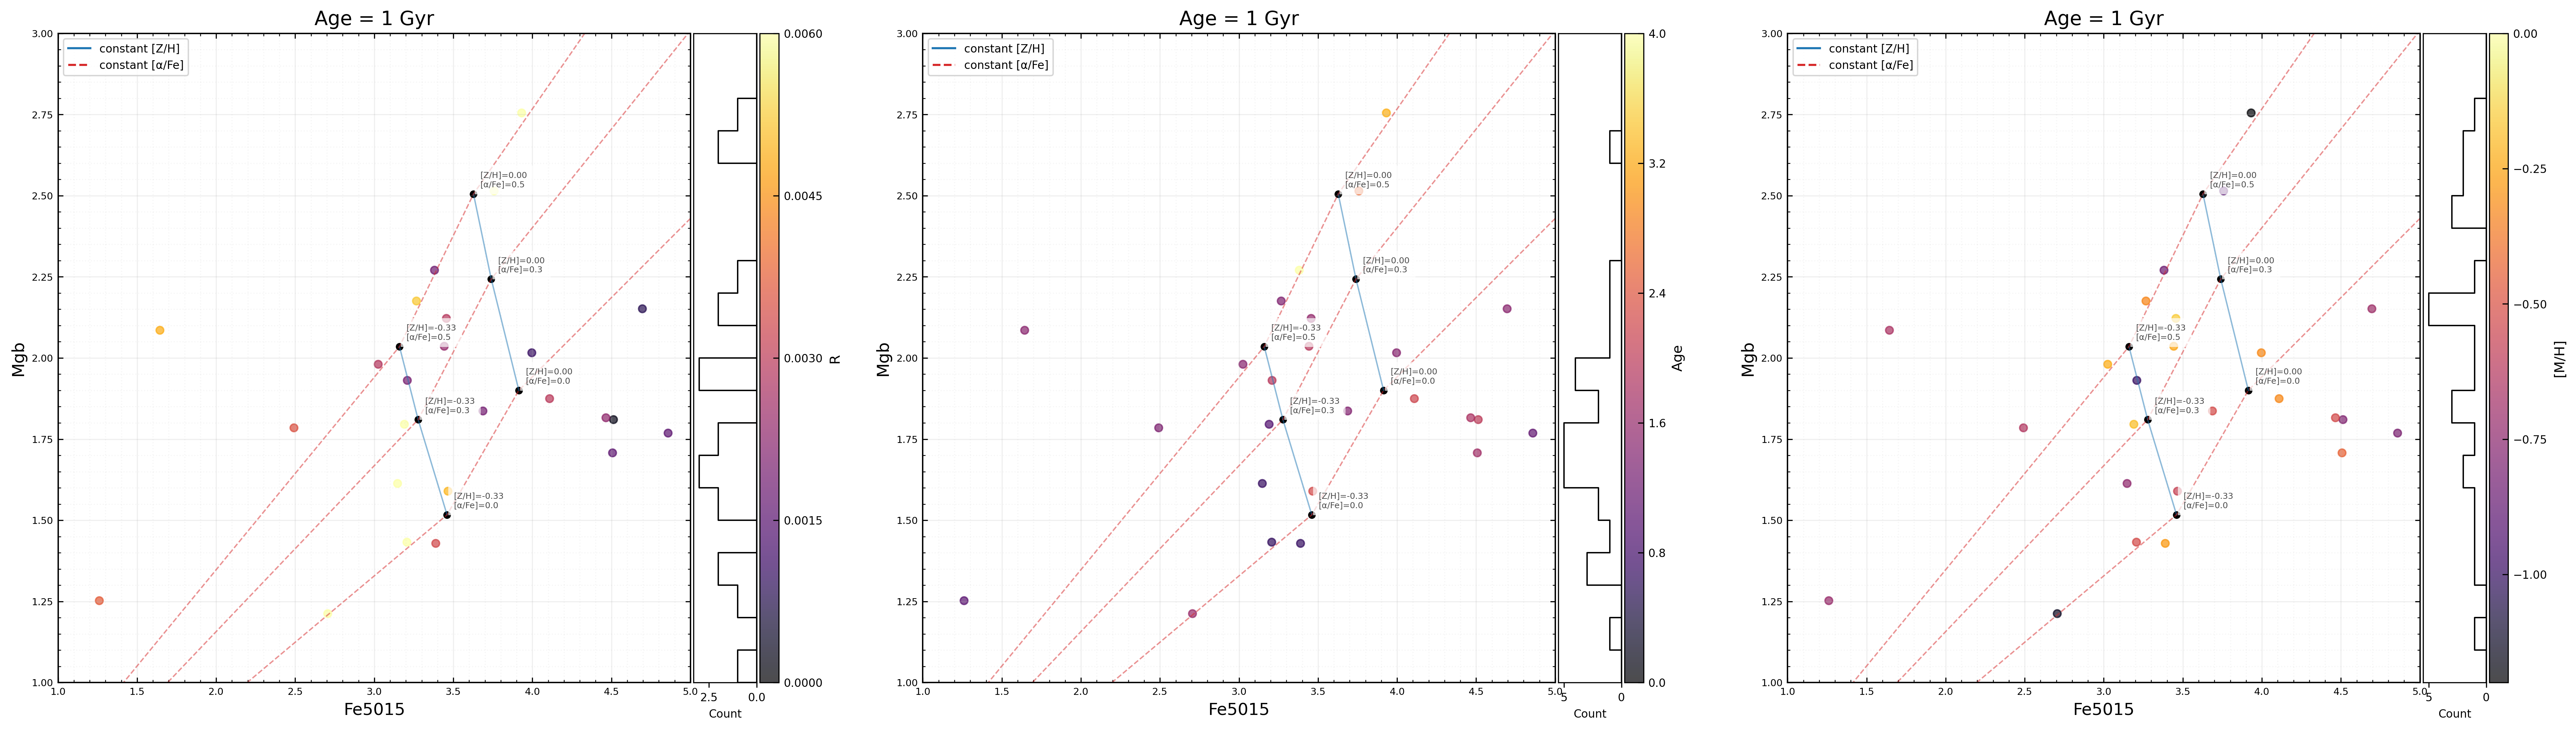

In [151]:
plotter = SpectrumIndexPlotter()
    
# 设置参数
data_file = './../TMB03/TMB03.csv'
x_range = (1, 5)
y_range = (1, 3)
ages = [1]
    
    # 准备数据列名映射
data_name = {
        'x': 'Fe_5015_SI',  # 观测数据中的X轴列名
        'y': 'Mg_b_SI',     # 观测数据中的Y轴列名
}
    
    # 设置颜色参数
color_params = [
        {'column': 'R', 'label': 'R', 'range': (0, 0.006)},
        {'column': 'Age', 'label': 'Age', 'range': (0, 4)},
        {'column': 'MOH', 'label': r'[M/H]', 'range': (-1.2, 0)},
    ]
fig = plotter.plot_index_grid(
        data_file=data_file,
        x_index='Fe5015',
        y_index='Mgb',
        x_range=x_range,
        y_range=y_range,
        ages=ages,
        data_df=Galaxy_VNB,
        data_name=data_name,
        color_params=color_params,
        show_errorbar=False,
        layout=(1,3),


        base_size=7,          # 基础大小
        height_scale=1.6,     # 高度缩放
        width_ratios=1,     # 宽度比例
        wspace=0.2,           # 水平间距
        hspace=0.3,           # 垂直间距
        dpi=300,
        hist_width="10%",     # 直方图宽度
        cbar_width="3%",      # colorbar宽度
        hist_pad=0.03,        # 间距
        cbar_pad=0.03,
        fig_scale=1.5         # 整体缩放
    )
plt.show()